<a href="https://colab.research.google.com/github/Raghu889/Face-detection-using-PCA/blob/main/Copy_of_Untitled2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import files
import zipfile
import os

# Upload the ZIP file
uploaded = files.upload()  # You'll be prompted to upload

# Unzip it
with zipfile.ZipFile('faces.zip', 'r') as zip_ref:
    zip_ref.extractall('my_images')  # Extract to 'my_images' folder

# Check contents
os.listdir('my_images')


Saving faces.zip to faces.zip


['faces']

In [ ]:
def load_images_from_folder(folder, image_size=(300, 300)):
    X = []
    y = []
    target_names = []
    label_map = {}
    label = 0

    for person_name in sorted(os.listdir(folder)):
        person_path = os.path.join(folder, person_name)
        if os.path.isdir(person_path):
            label_map[label] = person_name
            for image_name in os.listdir(person_path):
                img_path = os.path.join(person_path, image_name)
                img = cv2.imread(img_path)
                if img is not None:
                    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    resized = cv2.resize(gray, image_size)
                    X.append(resized.flatten())
                    y.append(label)
            label += 1

    return np.array(X), np.array(y), label_map


In [ ]:
data_dir = "/content/my_images/faces"  # replace with your dataset path
X, y, label_map = load_images_from_folder(data_dir, image_size=(300, 300))

In [ ]:
n_samples, n_features = X.shape
n_classes = len(np.unique(y))
print(f"Samples: {n_samples}, Features: {n_features}, Classes: {n_classes}")

Samples: 450, Features: 90000, Classes: 9


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [ ]:
n_components = 150
print(f"Extracting the top {n_components} eigenfaces")

Extracting the top 150 eigenfaces


In [ ]:
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
eigenfaces = pca.components_.reshape((n_components, 300, 300))

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


In [ ]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=5):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        if i >= len(images): break
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=10)
        plt.xticks(())
        plt.yticks(())


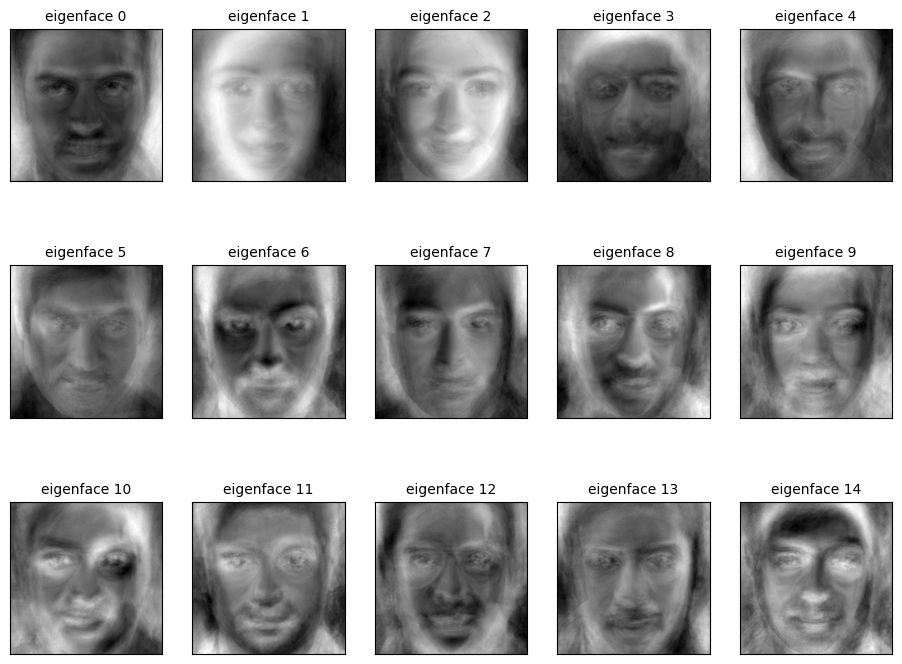

In [ ]:
eigenface_titles = [f"eigenface {i}" for i in range(len(eigenfaces))]
plot_gallery(eigenfaces, eigenface_titles, 300, 300)
plt.show()

In [ ]:
print("Projecting the input data on the LDA basis...")
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_pca, y_train)
X_train_lda = lda.transform(X_train_pca)
X_test_lda = lda.transform(X_test_pca)


Projecting the input data on the LDA basis...


In [ ]:
clf = MLPClassifier(
    random_state=1,
    hidden_layer_sizes=(10, 10),  # Two hidden layers with 10 neurons each
    max_iter=1000,                # Train for up to 1000 iterations
    verbose=True                  # Show progress during training
).fit(X_train_lda, y_train)

print("Model Weights:")
model_info = [coef.shape for coef in clf.coefs_]
print(model_info)


Iteration 1, loss = 3.26843725
Iteration 2, loss = 3.20540334
Iteration 3, loss = 3.14627728
Iteration 4, loss = 3.09158089
Iteration 5, loss = 3.03585955
Iteration 6, loss = 2.98253842
Iteration 7, loss = 2.92958023
Iteration 8, loss = 2.87837920
Iteration 9, loss = 2.82927682
Iteration 10, loss = 2.77993813
Iteration 11, loss = 2.73355188
Iteration 12, loss = 2.68646729
Iteration 13, loss = 2.64293007
Iteration 14, loss = 2.59777023
Iteration 15, loss = 2.55584819
Iteration 16, loss = 2.51455851
Iteration 17, loss = 2.47437915
Iteration 18, loss = 2.43549767
Iteration 19, loss = 2.39735821
Iteration 20, loss = 2.36069185
Iteration 21, loss = 2.32442253
Iteration 22, loss = 2.29096295
Iteration 23, loss = 2.25630834
Iteration 24, loss = 2.22422458
Iteration 25, loss = 2.19074820
Iteration 26, loss = 2.15897890
Iteration 27, loss = 2.12839000
Iteration 28, loss = 2.09753740
Iteration 29, loss = 2.06783598
Iteration 30, loss = 2.03719190
Iteration 31, loss = 2.00886976
Iteration 32, los

Accuracy: 72.57%


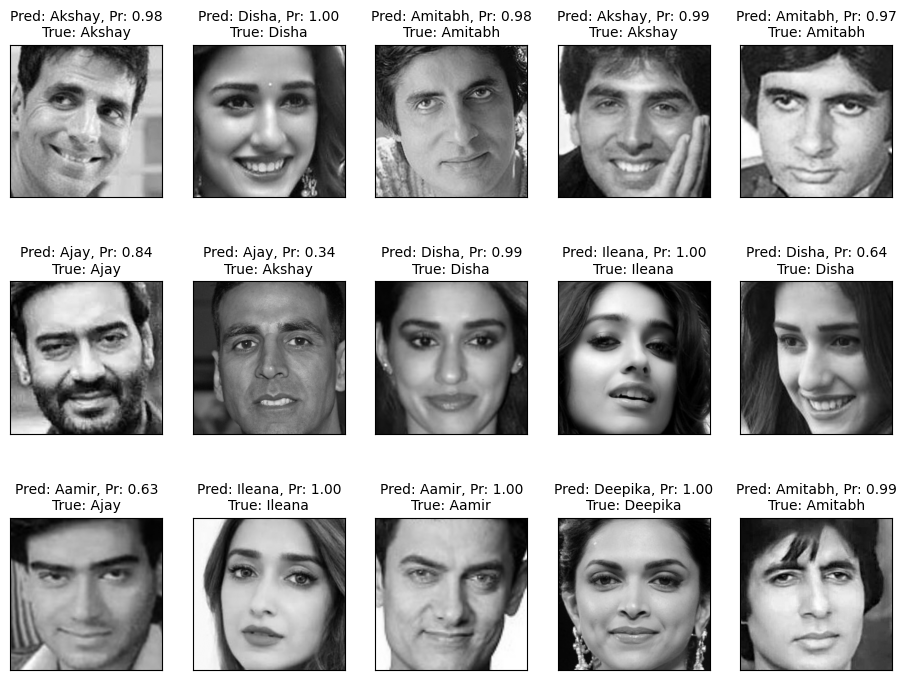

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Predict labels and probabilities for test data
y_pred = []
y_prob = []

for test_face in X_test_lda:
    prob = clf.predict_proba([test_face])[0]
    class_id = np.argmax(prob)
    y_pred.append(class_id)
    y_prob.append(np.max(prob))

# Convert to numpy array
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

# Initialize counters and prediction titles
prediction_titles = []
true_positive = 0

# Ensure `class_names` is correctly indexed (e.g., class_names[0] = "PersonA")
for i in range(len(y_test)):
    true_name = label_map[y_test[i]]
    pred_name = label_map[y_pred[i]]
    prob_str = f"{y_prob[i]:.2f}"

    result = f"Pred: {pred_name}, Pr: {prob_str}\nTrue: {true_name}"
    prediction_titles.append(result)

    if true_name == pred_name:
        true_positive += 1

# Calculate accuracy
accuracy = true_positive * 100 / len(y_pred)
print(f"Accuracy: {accuracy:.2f}%")

# Plot predictions
h,w=300,300
plot_gallery(X_test, prediction_titles, h, w)
plt.show()
